## This Jupyter notebook is an example of how to use the backend functions from PROJECT NAME THAT I CANT REMEMBER NOW

Our first cell imports our analyser, as well as numpy and pandas

In [2]:
from backend_widgets import *
import numpy as np

import pandas as pd

Now we define some functions so that a user can create some generic data.

The functions "rotate" and "normal_cloud" are best called via "separate_gaussians".

"Separate_gaussians" creates two 2D gaussian ellipses, which are then randomly rotated.
It labels one cloud as +ve and one as -ve.

# Application of analyser to SKLearn toy datasets

In its current form this notebook applies the analyser to the sklearn toy datasets.
The user can change the line
```dataset = datasets.load_wine()```
to any of
```.load_breast_cancer, .load_iris, .load_wine```
for classification examples, or
```.load_diabetes```
for regression.

In [3]:
from sklearn import datasets
%matplotlib inline

#data = construct_example_dataset(n_dimensions=2, circular=True)

dataset = datasets.load_wine()
data = construct_sklearn_dataset(dataset)

#Finally, initiate the analyser
analyse = analyser(data, "target")
analyse.analyse()

analyser active


# Mean separations & feature correlations

The analyser class includes methods to find the separations of class means, as well as feature correlations

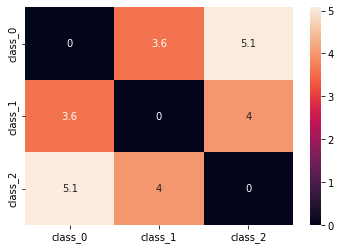

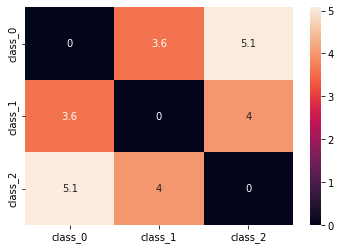

In [3]:
analyse.mean_separations()

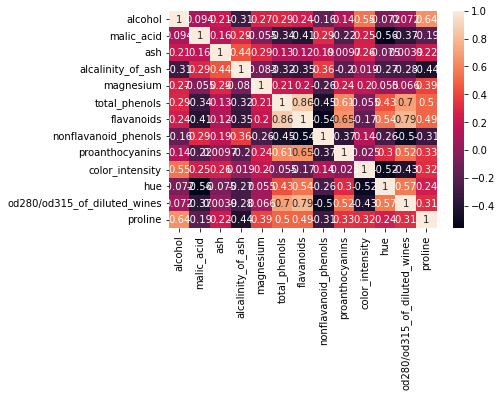

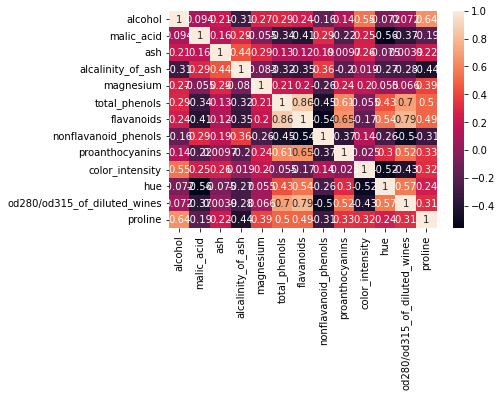

In [4]:
analyse.feature_correlations(display=True)

# The ```.compare(x1,x2)``` method
This allows comparison of any two variables.
It draws confidence interval ellipses around the classes in the given x1 vs x2 dataspace, if the problem is classification.
It also displays histograms of the data in x1 and x2, aligned with the axis.
The main aim here is to check if data is easily separable along the given dimensions.


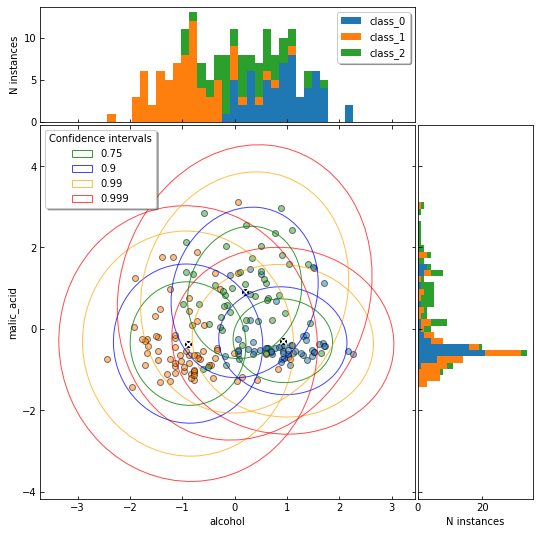

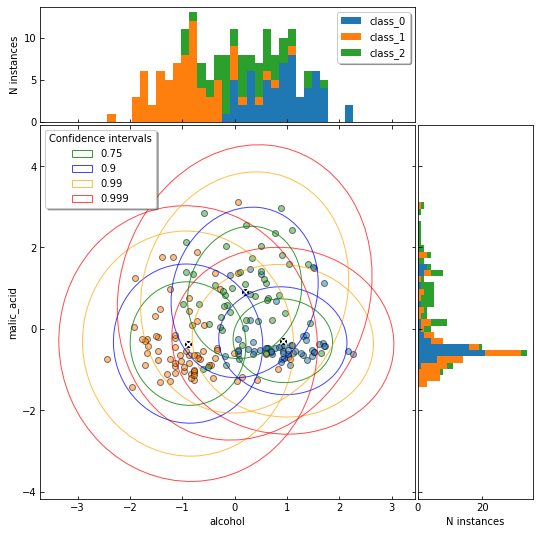

In [5]:
analyse.compare(analyse.datacols[0], analyse.datacols[1])

# Feature importances

Using SKLearn random forest ensembles allows us to find the comparative utility of features from both a classification and regression perspective.
This is returned to the user, and ```.compare``` is called on the two most "important" features.
Note here that random forests are stochastic in nature, and results may vary between runs on the same data.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished


(array(['proline', 'color_intensity', 'flavanoids', 'alcohol',
       'od280/od315_of_diluted_wines', 'hue', 'total_phenols',
       'magnesium', 'malic_acid', 'alcalinity_of_ash', 'proanthocyanins',
       'ash', 'nonflavanoid_phenols'], dtype='<U28'), <Figure size 576x576 with 3 Axes>)


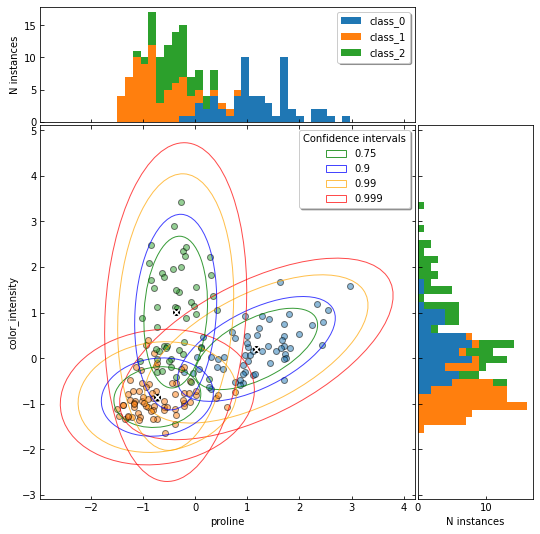

In [6]:
feature_importances = analyse.feature_importances()
print(feature_importances)

# Linear separability

The class also includes the ```.linear_separable()``` method to test whether data is linearly separable
It also has functionality to use different kernels and different orders within those kernels

In [7]:
analyse.linear_separable(kernel = 'poly', order=1)
analyse.linear_separable(kernel = 'poly', order=2)
analyse.linear_separable(kernel = 'poly', order=3)

Data is perfectly linearly separable, to an accuracy of 1.0
Data is perfectly linearly separable, to an accuracy of 1.0
Data is perfectly linearly separable, to an accuracy of 1.0


# Dimensionality reduction

We also include methods to add dimensionality reduction projections to the backend dataframe.
The kwarg ```display``` allows the user to see the result using ```.compare```.

In its current form this is implemented for PCA and TSNE and UMAP.
PCA uses class correlations, whereas TSNE and UMAP attempt to find an embedding of an underlying
manifold in the data-space.

Dimensionality reduction is often useful to find underlying patterns in the data, reduce the number of features passed to
algorithms, or to improve class separability.

/Users/alexdavies/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/alexdavies/miniforge3/envs/testenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


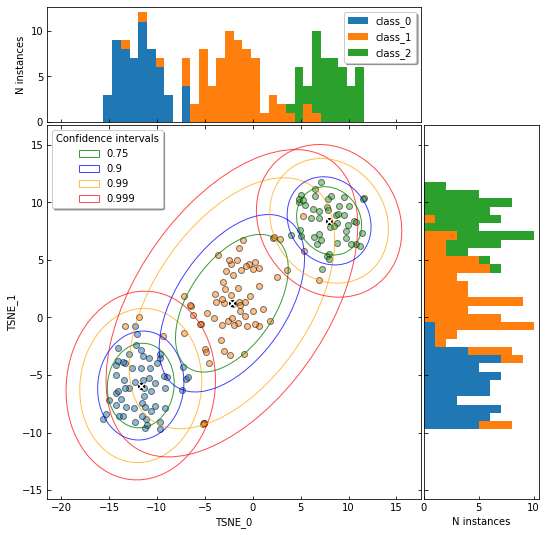

In [8]:
analyse.add_TSNE(display = True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.1s finished


(array(['TSNE_0', 'TSNE_1', 'color_intensity', 'flavanoids', 'proline',
       'od280/od315_of_diluted_wines', 'alcohol', 'hue', 'total_phenols',
       'malic_acid', 'proanthocyanins', 'alcalinity_of_ash', 'magnesium',
       'ash', 'nonflavanoid_phenols'], dtype='<U28'), <Figure size 576x576 with 3 Axes>)


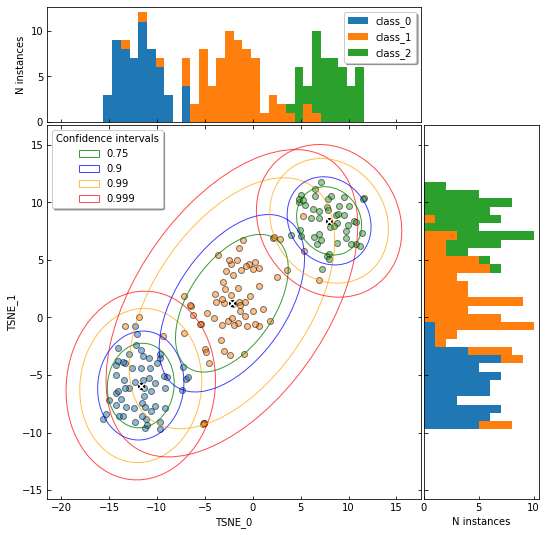

In [9]:
feature_importances = analyse.feature_importances()
print(feature_importances)

In [10]:
analyse.linear_separable(kernel = 'poly', order=1)
analyse.linear_separable(kernel = 'poly', order=2)
analyse.linear_separable(kernel = 'poly', order=3)

Data is perfectly linearly separable, to an accuracy of 1.0
Data is perfectly linearly separable, to an accuracy of 1.0
Data is perfectly linearly separable, to an accuracy of 1.0
